## COVID-19 Analysis for INDIA

In [26]:
import findspark
findspark.init()

In [27]:
import os
import re
import numpy
import pyspark

import pyspark.sql.types as ptypes
import pyspark.sql.window as wndws
import pyspark.sql.functions as funcs

In [28]:
ss = (pyspark.sql.SparkSession
      .builder.master('local[*]')
      .appName('Indian COVID-19 Analysis').getOrCreate())

In [29]:
ss

In [30]:
%matplotlib inline
%config InlineBackend.rc = {'figure.figsize': (16, 6)}

In [31]:
def __order_df_and_add_missing_cols(df, columns_order_list, df_missing_fields):
    """ return ordered dataFrame by the columns order list with null in missing columns """
    if not df_missing_fields:  # no missing fields for the df
        return df.select(columns_order_list)
    else:
        columns = []
        for colName in columns_order_list:
            if colName not in df_missing_fields:
                columns.append(colName)
            else:
                columns.append(funcs.lit(None).alias(colName))
        return df.select(columns)


def __add_missing_columns(df, missing_column_names):
    """ Add missing columns as null in the end of the columns list """
    list_missing_columns = []
    for col in missing_column_names:
        list_missing_columns.append(funcs.lit(None).alias(col))

    return df.select(df.schema.names + list_missing_columns)


def __order_and_union_d_fs(left_df, right_df, left_list_miss_cols, right_list_miss_cols):
    """ return union of data frames with ordered columns by left_df. """
    left_df_all_cols = __add_missing_columns(left_df, left_list_miss_cols)
    right_df_all_cols = __order_df_and_add_missing_cols(right_df, left_df_all_cols.schema.names,
                                                        right_list_miss_cols)
    return left_df_all_cols.union(right_df_all_cols)


def union_d_fs(left_df, right_df):
    """ Union between two dataFrames, if there is a gap of column fields,
     it will append all missing columns as nulls """
    # Check for None input
    if left_df is None:
        raise ValueError('left_df parameter should not be None')
    if right_df is None:
        raise ValueError('right_df parameter should not be None')
        # For data frames with equal columns and order- regular union
    if left_df.schema.names == right_df.schema.names:
        return left_df.union(right_df)
    else:  # Different columns
        # Save dataFrame columns name list as set
        left_df_col_list = set([st.strip() for st in left_df.schema.names])
        right_df_col_list = set([st.strip() for st in right_df.schema.names])
        # Diff columns between left_df and right_df
        right_list_miss_cols = list(left_df_col_list - right_df_col_list)
        left_list_miss_cols = list(right_df_col_list - left_df_col_list)
        return __order_and_union_d_fs(left_df, right_df, left_list_miss_cols, right_list_miss_cols)


In [32]:
states_and_ut = {
    'ap': ('ap', 'andhra pradesh'), 'ar': ('ar', 'arunachal pradesh'), 'as': ('as', 'assam'),
    'br': ('br', 'bihar'), 'cg': ('cg', 'chattisgarh', 'chhattisgarh'), 'ga': ('ga', 'goa'), 
    'gj': ('gj', 'gujarat'), 'chhattisgarh': ('cg', 'chattisgarh', 'chhattisgarh'),
    'hr': ('hr', 'haryana'), 'hp': ('hp', 'himachal pradesh'), 'jh': ('jh', 'jharkhand'),
    'ka': ('ka', 'karnataka'), 'kl': ('kl', 'kerela', 'kerala'), 
    'mp': ('mp', 'madhya pradesh'), 'kerala': ('kl', 'kerela', 'kerala'),
    'mh': ('mh', 'maharashtra'), 'mn': ('mn', 'manipur'), 'ml': ('ml', 'meghalaya'),
    'mz': ('mz', 'mizoram'), 'nl': ('nl', 'nagaland'), 'or': ('or', 'odisha'), 'pb': ('pb', 'punjab'),
    'rj': ('rj', 'rajasthan'), 'sk': ('sk', 'sikkim'), 'tn': ('tn', 'tamil nadu'),
    'tg': ('tg', 'telangana'), 'tr': ('tr', 'tripura'), 'uk': ('uk', 'uttarakhand'),
    'up': ('up', 'uttar pradesh'), 'wb': ('wb', 'west bengal'), 'an': ('an', 'andaman and nicobar'),
    'ch': ('ch', 'chandigarh'), 'dn': ('dn', 'dadraand nagar haveli'), 'dd': ('dd', 'daman and diu'),
    'dl': ('dl', 'delhi'), 'jk': ('jk', 'jammu and kashmir'), 'la': ('la', 'ladakh'),
    'ld': ('ld', 'lakshadweep'), 'py': ('py', 'puducherry'), 'andhra pradesh': ('ap', 'andhra pradesh'),
    'arunachal pradesh': ('ar', 'arunachal pradesh'), 'assam': ('as', 'assam'), 'bihar': ('br', 'bihar'),
    'chattisgarh': ('cg', 'chattisgarh'), 'goa': ('ga', 'goa'), 'gujarat': ('gj', 'gujarat'),
    'haryana': ('hr', 'haryana'), 'himachal pradesh': ('hp', 'himachal pradesh'),
    'jharkhand': ('jh', 'jharkhand'), 'karnataka': ('ka', 'karnataka'), 'kerela': ('kl', 'kerela'),
    'madhya pradesh': ('mp', 'madhya pradesh'), 'maharashtra': ('mh', 'maharashtra'),
    'manipur': ('mn', 'manipur'), 'meghalaya': ('ml', 'meghalaya'), 'mizoram': ('mz', 'mizoram'),
    'nagaland': ('nl', 'nagaland'), 'odisha': ('or', 'odisha'), 'punjab': ('pb', 'punjab'),
    'rajasthan': ('rj', 'rajasthan'), 'sikkim': ('sk', 'sikkim'), 'tamil nadu': ('tn', 'tamil nadu'),
    'telangana': ('tg', 'telangana'), 'tripura': ('tr', 'tripura'), 'uttarakhand': ('uk', 'uttarakhand'),
    'uttar pradesh': ('up', 'uttar pradesh'), 'west bengal': ('wb', 'west bengal'),
    'andaman and nicobar': ('an', 'andaman and nicobar', 'andaman and nicobar islands'),
    'andaman and nicobar islands': ('an', 'andaman and nicobar', 'andaman and nicobar islands'),
    'chandigarh': ('ch', 'chandigarh'),
    'dadraand nagar haveli': ('dn', 'dadraand nagar haveli'), 'daman and diu': ('dd', 'daman and diu'),
    'delhi': ('dl', 'delhi'), 'jammu and kashmir': ('jk', 'jammu and kashmir'), 'ladakh': ('la', 'ladakh'),
    'lakshadweep': ('ld', 'lakshadweep'), 'puducherry': ('py', 'puducherry'),
    'un': ('un', 'state unassigned'), 'state unassigned': ('un', 'state unassigned'),
}

In [33]:
def replace_column_names(df):
    return df.select(
        [funcs.col(cl).alias(cl.strip().lower().replace(' ', '_')) for cl in df.columns]
    )

In [34]:
current_dir_path = os.path.abspath(os.path.curdir)
csv_file_path = f'{current_dir_path}/data/source/COVID19India/raw_data1.csv'
covid_india_df = ss.read.csv(csv_file_path, inferSchema=True, header=True, 
                             multiLine=True, quote='"' ,escape='"', sep=',')
covid_india_df = replace_column_names(covid_india_df)

for nth in range(2, 25):
    tmp_csv_file_path = f'{current_dir_path}/data/source/COVID19India/raw_data{nth}.csv'
    tmp_covid_india_df = ss.read.csv(tmp_csv_file_path,  header=True, multiLine=True, 
                                     inferSchema=True, quote='"' ,escape='"', sep=',')
    tmp_covid_india_df = replace_column_names(tmp_covid_india_df)
    covid_india_df = union_d_fs(covid_india_df, tmp_covid_india_df)

In [35]:
covid_india_df.printSchema()

root
 |-- patient_number: string (nullable = true)
 |-- state_patient_number: string (nullable = true)
 |-- date_announced: string (nullable = true)
 |-- estimated_onset_date: string (nullable = true)
 |-- age_bracket: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- detected_city: string (nullable = true)
 |-- detected_district: string (nullable = true)
 |-- detected_state: string (nullable = true)
 |-- state_code: string (nullable = true)
 |-- current_status: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- contracted_from_which_patient_(suspected): string (nullable = true)
 |-- nationality: string (nullable = true)
 |-- type_of_transmission: string (nullable = true)
 |-- status_change_date: string (nullable = true)
 |-- source_1: string (nullable = true)
 |-- source_2: string (nullable = true)
 |-- source_3: string (nullable = true)
 |-- backup_notes: string (nullable = true)
 |-- num_cases: double (nullable = true)
 |-- entry_id: integer (nullab

In [36]:
def correct_status(sts):
    if not sts:
        return sts
    if sts.lower() == 'migrated':
        return 'Migrated Other'
    return sts.replace('_', ' ').title()

correct_status_udf = funcs.udf(correct_status)

In [37]:
def clean_age_bracket(age):
    pattrn = r'\d+.\d+|\d+'
    age_tmp = re.findall(pattrn, str(age))
    if (not age) and (not age_tmp):
        return age
    
    # Clean values like 28-35 age
    if age_tmp and age_tmp[0].__contains__('-'):
        return [float(n) for n in age_tmp[0].split('-') if n][0]
    
    age = age.lower()
    if age.__contains__('month'):
        return round(((float(age_tmp[0]) * 30) / 365), 3)
    elif age.__contains__('day'):
        return round((float(age_tmp[0]) / 365), 3)
    if age_tmp:
        return float(age_tmp[0])
    else:
        return 'null'

clean_age_bracket_udf = funcs.udf(clean_age_bracket)

In [38]:
def clear_gender(txt):
    if not txt:
        return txt
    elif txt.lower().strip() in ['non-binary', 'na']:
        return 'Other'
    elif txt.lower().strip() in ['m', 'm,', 'male']:
        return 'Male'
    else:
        return 'Female'

clear_gender_udf = funcs.udf(clear_gender)

In [39]:
def clean_notes(txt):
    if not txt:
        return txt
    elif txt.lower().strip().__contains__('travel'):
        return 'Yes'
    return 'No'

clean_notes_udf = funcs.udf(clean_notes)

In [40]:
def cleaning_states_and_codes_udf(st_cd, st_nm, op_type='code'):
    
    if not any([st_cd, st_nm]):
        return st_cd if (op_type == 'code') else st_nm
    
    def text_cleaner(txt):
        return txt.lower().strip()
    
    def validate_text(txt, index=0):
        searched = states_and_ut.get(txt, [])
        if txt in searched:
            return searched[index].title() if (index==1) else searched[index].upper()
    
    if op_type == 'code':
        if st_cd:
            cld_cd = text_cleaner(st_cd)
            vld_cd = validate_text(cld_cd)
            if vld_cd:
                return vld_cd
        elif st_nm:
            cld_st = text_cleaner(st_nm)
            vld_st = validate_text(cld_st)
            if vld_st:
                return vld_st
        return st_cd
    elif op_type == 'state':
        if st_nm:
            cld_nm = text_cleaner(st_nm)
            vld_nm = validate_text(cld_nm, 1)
            if vld_nm:
                return vld_nm
        elif st_cd:
            cld_cd = text_cleaner(st_cd)
            vld_cd = validate_text(cld_cd, 1)
            if vld_cd:
                return vld_cd
        return st_nm

cleaning_states_and_codes_udf = funcs.udf(cleaning_states_and_codes_udf)

In [41]:
covid_india_df = (
    covid_india_df
    .withColumn('current_status', correct_status_udf(funcs.col('current_status')))
    .withColumn('date_announced', funcs.from_unixtime(funcs.unix_timestamp('date_announced', 'dd/MM/yyyy')))
    .withColumn('full_weekday', funcs.date_format(funcs.col('date_announced'), 'EEEE'))
    .withColumn('month', funcs.date_format(funcs.col('date_announced'), 'MMM'))
    .withColumn('day_of_year', funcs.date_format(funcs.col('date_announced'), 'D').cast(ptypes.IntegerType()))
    .withColumn('quarter_of_year', funcs.date_format(funcs.col('date_announced'), 'q').cast(ptypes.IntegerType()))
    .withColumn('year', funcs.date_format(funcs.col('date_announced'), 'yyyy').cast(ptypes.IntegerType()))
    .withColumn('week_of_year', funcs.weekofyear(funcs.col('date_announced')).cast(ptypes.IntegerType()))
    .withColumn('month_and_year', funcs.date_format(funcs.col('date_announced'), 'MM-yyyy'))
    .withColumn('age_bracket', clean_age_bracket_udf(funcs.col('age_bracket')).cast(ptypes.FloatType()))
    .withColumn('gender', clear_gender_udf(funcs.col('gender')).cast(ptypes.StringType()))
    .withColumn('travel', clean_notes_udf(funcs.col('notes')).cast(ptypes.StringType()))
    .withColumn('num_cases', covid_india_df['num_cases'].cast(ptypes.IntegerType()))
    .withColumn('state_code', 
                cleaning_states_and_codes_udf(
                    funcs.col('state_code'), 
                    funcs.col('detected_state'), 
                    funcs.lit('code'))
               )
    .withColumn('detected_state', 
                cleaning_states_and_codes_udf(
                    funcs.col('state_code'), 
                    funcs.col('detected_state'), 
                    funcs.lit('state'))
               )
)

In [42]:
covid_india_df = covid_india_df.fillna({'nationality': 'India'})

In [43]:
covid_india_df = (covid_india_df.drop(*[
    'estimated_onset_date', 'contracted_from_which_patient_(suspected)', 'status_change_date',
    'type_of_transmission', 'source_1', 'source_2', 'source_3', 'backup_notes'
]))

### Check nulls

In [44]:
covid_india_df.select(
    [
        funcs.count(
            funcs.when((funcs.isnan(clm) | funcs.col(clm).isNull()), clm)
        ).alias(clm) for clm in covid_india_df.columns
    ]
).show()

+--------------+--------------------+--------------+-----------+------+-------------+-----------------+--------------+----------+--------------+------+-----------+---------+--------+------------+-----+-----------+---------------+----+------------+--------------+------+
|patient_number|state_patient_number|date_announced|age_bracket|gender|detected_city|detected_district|detected_state|state_code|current_status| notes|nationality|num_cases|entry_id|full_weekday|month|day_of_year|quarter_of_year|year|week_of_year|month_and_year|travel|
+--------------+--------------------+--------------+-----------+------+-------------+-----------------+--------------+----------+--------------+------+-----------+---------+--------+------------+-----+-----------+---------------+----+------------+--------------+------+
|           312|              439537|             7|     435677|433405|       539272|            13498|            23|        23|            14|436655|          0|       20|   28187|        

### Saveing all cleaned data in a single CSV file

In [45]:
(covid_india_df.repartition(1).write
 .csv(f'{current_dir_path}/data/source/collected_covid19_india_data.csv', mode='overwrite', header=True))

In [46]:
%matplotlib inline
%config InlineBackend.rc = {'figure.figsize': (16, 6)}

### State wise total cases infected by COVID-19

<AxesSubplot:xlabel='State Code', ylabel='No. Of Cases'>

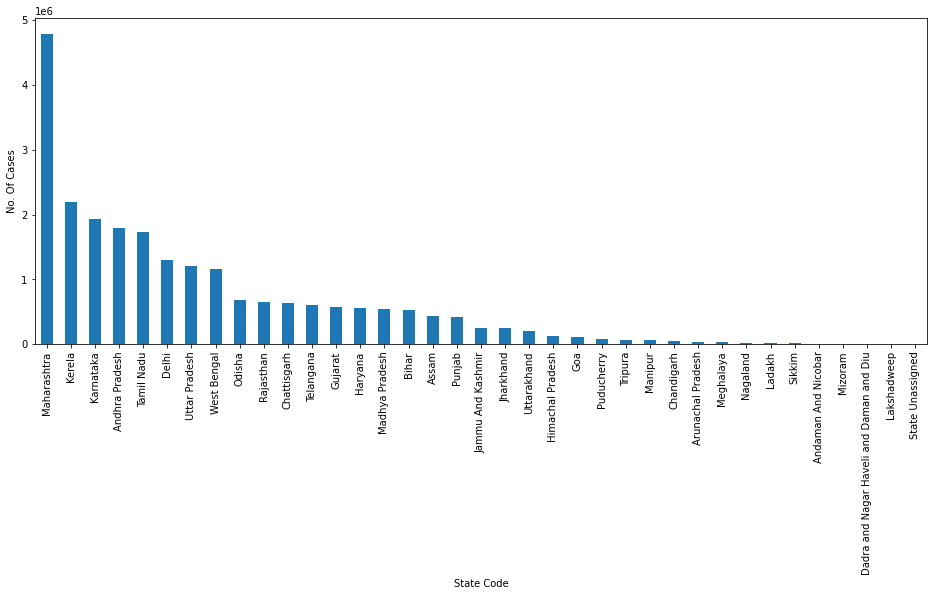

In [47]:
(covid_india_df
 .filter((covid_india_df['state_code'].isNotNull() & covid_india_df['detected_state'].isNotNull()))
 .groupby('detected_state').sum('num_cases')
 .sort('sum(num_cases)', ascending=False)
 .toPandas().plot(kind='bar', x='detected_state', xlabel='State Code', ylabel='No. Of Cases', legend=False))

In [48]:
(covid_india_df
 .filter((covid_india_df['state_code'].isNotNull() & covid_india_df['detected_state'].isNotNull()))
 .groupby('detected_state').sum('num_cases')
 .sort('sum(num_cases)', ascending=False).show(40))

+--------------------+--------------+
|      detected_state|sum(num_cases)|
+--------------------+--------------+
|         Maharashtra|       4791883|
|              Kerela|       2186513|
|           Karnataka|       1928826|
|      Andhra Pradesh|       1785444|
|          Tamil Nadu|       1727071|
|               Delhi|       1292879|
|       Uttar Pradesh|       1212403|
|         West Bengal|       1158299|
|              Odisha|        677105|
|           Rajasthan|        647376|
|         Chattisgarh|        642119|
|           Telangana|        603611|
|             Gujarat|        568987|
|             Haryana|        555486|
|      Madhya Pradesh|        545153|
|               Bihar|        526700|
|               Assam|        435663|
|              Punjab|        412088|
|   Jammu And Kashmir|        255879|
|           Jharkhand|        241930|
|         Uttarakhand|        196184|
|    Himachal Pradesh|        120347|
|                 Goa|        112392|
|          P

### Total number of cases as per the status

In [49]:
(covid_india_df
 .filter(covid_india_df['current_status'].isNotNull())
 .groupby('current_status').agg(
    funcs.sum('num_cases').alias('total_num_cases')
)).sort('total_num_cases', ascending=False).show(550)

+--------------+---------------+
|current_status|total_num_cases|
+--------------+---------------+
|  Hospitalized|       11686103|
|     Recovered|       11172754|
|      Deceased|         159364|
|Migrated Other|           4732|
+--------------+---------------+



### State wise status of infected

In [50]:
(covid_india_df
 .groupby('detected_state', 'current_status')
 .agg(funcs.sum('num_cases').alias('total_num_cases'))
).sort('total_num_cases', ascending=False).show()

+--------------+--------------+---------------+
|detected_state|current_status|total_num_cases|
+--------------+--------------+---------------+
|   Maharashtra|  Hospitalized|        2504313|
|   Maharashtra|     Recovered|        2233145|
|        Kerela|  Hospitalized|        1105407|
|        Kerela|     Recovered|        1076287|
|     Karnataka|  Hospitalized|         971575|
|     Karnataka|     Recovered|         944796|
|Andhra Pradesh|  Hospitalized|         894042|
|Andhra Pradesh|     Recovered|         884242|
|    Tamil Nadu|  Hospitalized|         868360|
|    Tamil Nadu|     Recovered|         846125|
|         Delhi|  Hospitalized|         648868|
|         Delhi|     Recovered|         633100|
| Uttar Pradesh|  Hospitalized|         608067|
| Uttar Pradesh|     Recovered|         595601|
|   West Bengal|  Hospitalized|         580993|
|   West Bengal|     Recovered|         567015|
|        Odisha|  Hospitalized|         338962|
|        Odisha|     Recovered|         